In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from prettytable import PrettyTable
import random
from scipy.stats import norm
from scipy.stats.stats import pearsonr
import statsmodels.api as sm
import plotly.graph_objects as go

# **Task 1**
Load the dataset and print the total number of samples, column names, null values in each column, and data types of the columns. Remove the samples that have null values.

In [ ]:
!gdown --id 1bTtIDHMP6a5dQ3a2Aw9AAR8Flprjb3Ei

Downloading...
From: https://drive.google.com/uc?id=1bTtIDHMP6a5dQ3a2Aw9AAR8Flprjb3Ei
To: /content/data.csv
100% 527k/527k [00:00<00:00, 33.3MB/s]


In [ ]:
data=pd.read_csv('/content/data.csv')

print(f'Total number of samples: {data.shape[0]}')
print(f'Column Names: {data.columns.values}')
print(f'Number of null values in each column:\n{data.isnull().sum()}')
print(f'Datatypes of each column:\n{data.dtypes}')

data.info()
#data.isnull().sum()
data=data.dropna()
#sns.heatmap(data.isnull())

Total number of samples: 4600
Column Names: ['date' 'price' 'bedrooms' 'bathrooms' 'sqft_living' 'sqft_lot' 'floors'
 'waterfront' 'view' 'condition' 'sqft_above' 'sqft_basement' 'yr_built'
 'yr_renovated' 'street' 'city' 'statezip' 'country']
Number of null values in each column:
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
street           0
city             0
statezip         0
country          0
dtype: int64
Datatypes of each column:
date              object
price            float64
bedrooms         float64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated

# **Task 2**

Some of the features need to be pre-processed at first before proceeding with Linear Regression. See the Lab Report for detailed reasoning behind the pre-processing steps.</br>

**Price:**
There are 49 entries in the dataframe where the price is listed as \$0. These entries have to be pruned as they won't contribute anything to our model. There is also an entry where is the price tag is \$26590000. This is clearly an outlier data-point since the rest of the house prices are way too low compared to this house.

**Bedrooms:**
There are 2 entries with 0 bedrooms. These entries should be pruned as well. Comparatively, a very small number of houses in the dataframe have more than 6 bedrooms. I replaced these entries to have 6 bedrooms for better generalization.

**Statezip:**
I can't discard all of the address columns as real-estate prices depend a lot on the vicinity of houses. Instead of keeping the `statezip` column's data as strings, I converted it to integers. Now, I can easily and efficiently categorize the houses based on whether they are situated in an affluent area or not. The `affluentArea` column signifies that status.

**Year Renovated:**
Apparently, the price of a house depends on whether it has been renovated or not and the time of renovation is not relevant. So, I converted the `yr_renovated` column to `isRenovated` which signifies the boolean status of renovation of a house.

In [ ]:
data = data[(data.price<2.5*10**7) & (data.bedrooms>0) & (data.price>0)].copy()
data['statezip']=(data['statezip'].str.replace('WA ', '')).astype(int)
data['isRenovated'] = (data.yr_renovated>0).astype(int)
data['bedrooms']=data['bedrooms'].replace([7,8,9],6)
data['affluentArea']=data['statezip'].isin([98039.0,98004.0,98040.0,98109.0]).astype(int)

[[1.000e+00 3.000e+00 1.500e+00 ... 1.955e+03 1.000e+00 0.000e+00]
 [1.000e+00 5.000e+00 2.500e+00 ... 1.921e+03 0.000e+00 0.000e+00]
 [1.000e+00 3.000e+00 2.000e+00 ... 1.966e+03 0.000e+00 0.000e+00]
 ...
 [1.000e+00 3.000e+00 2.500e+00 ... 2.009e+03 0.000e+00 0.000e+00]
 [1.000e+00 4.000e+00 2.000e+00 ... 1.974e+03 0.000e+00 0.000e+00]
 [1.000e+00 3.000e+00 2.500e+00 ... 1.990e+03 0.000e+00 0.000e+00]]
[[ 313000.      ]
 [2384000.      ]
 [ 342000.      ]
 ...
 [ 416904.166667]
 [ 203400.      ]
 [ 220600.      ]]


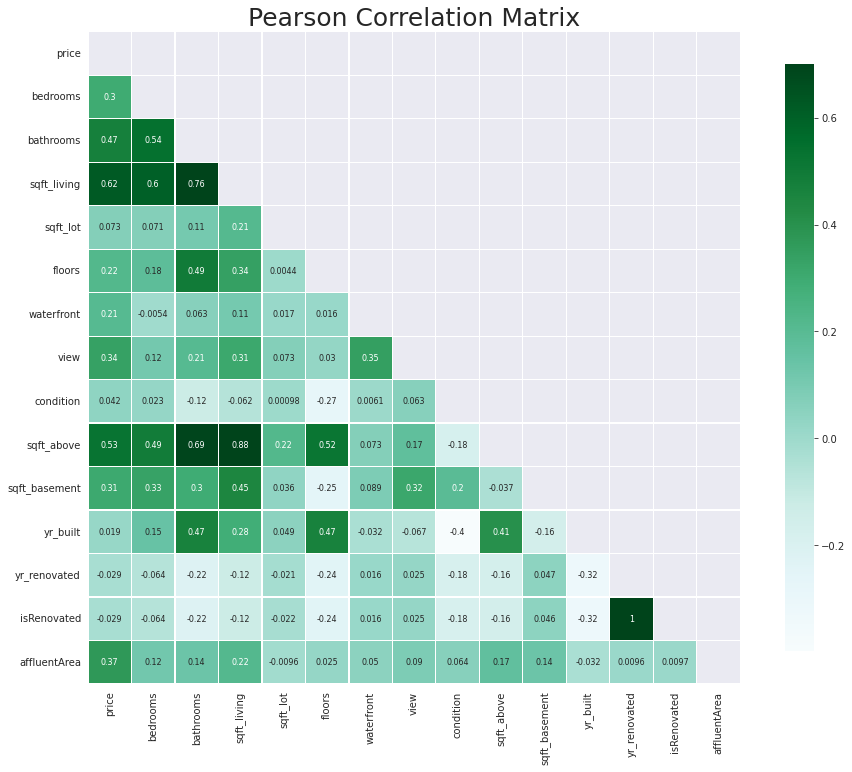

In [ ]:
features = ['price','bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated','isRenovated','affluentArea']
mask = np.zeros_like(data[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(data[features].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});
data.head(5)
X=data[['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition','sqft_above','sqft_basement','yr_built','isRenovated','affluentArea']].values
y=data['price'].values.reshape(-1,1)
#X=np.c_[np.ones(X.shape[0]),np.array(X)]
X = np.concatenate((np.ones((len(X),1)),X),axis=1)
print(X)
print(y)

# **Task 3**
Split the dataset into training and test sets. The ratio should be 80-20.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

**Z-score** normalization on the training set. <br>
<center>
<img src="https://d1whtlypfis84e.cloudfront.net/guides/wp-content/uploads/2020/04/04155631/1426878678.png">
</center>

In [ ]:
X_trainMean=X_train.mean(axis=0)
X_trainStdDev=X_train.std(axis=0)
X_trainMean[0]=0
X_trainStdDev[0]=1
X_trainNorm=(X_train-X_trainMean)/X_trainStdDev

y_trainMean=y_train.mean()
y_trainStdDev=y_train.std()
y_trainNorm=(y_train-y_trainMean)/y_trainStdDev

print(X_trainMean,X_trainStdDev,y_trainMean,y_trainStdDev)

[0.00000000e+00 3.38949973e+00 2.16094008e+00 2.13549093e+03
 1.46586627e+04 1.51869159e+00 6.32215503e-03 2.38042881e-01
 3.44777350e+00 1.82799643e+03 3.07494502e+02 1.97098900e+03
 3.96096756e-01 4.53545904e-02] [1.00000000e+00 8.81842817e-01 7.67908704e-01 9.48193121e+02
 3.69498473e+04 5.41369634e-01 7.92602384e-02 7.71584204e-01
 6.77847255e-01 8.54041316e+02 4.55379471e+02 2.98525861e+01
 4.89084978e-01 2.08080637e-01] 552161.9759527791 414535.61315414903


**Hypothesis** <br>
![image.png](https://miro.medium.com/max/512/1*U4W4RljYFmJQVsLi4YVozw.png)

**Mean Squared Error** <br>
![image1.png](https://miro.medium.com/max/336/1*rZjirMxeNnyJvziPsOv6Xw.png)

**Derivative** <br>
![image2.png](https://miro.medium.com/max/283/1*TYSV4TecQ9DgSZ_sAQD1mw.png)

In [ ]:
epochList=[]

def MSE(X_, y_, theta):
    J=(1/(2*X_.shape[0]))*np.dot(np.transpose((np.dot(X_,theta) - y_)),(np.dot(X_,theta) - y_)) # For de-normalizing J=(1/(2*X_.shape[0]))*np.dot(np.transpose(((np.dot(X_,theta)*y_trainStdDev + y_trainMean) - y_)),((np.dot(X_,theta)*y_trainStdDev + y_trainMean) - y_))
    return J[0,0]

def gradient_descent(X_, y_, lr, epoch):
    m=X_.shape[0]
    n=X_.shape[1]
    theta=np.ones(n).reshape(-1,1)
    mse=[]
    for iter in range(epoch):
        epochList.append(iter)
        dTheta=(1/m)*np.dot(np.transpose(X_),(np.dot(X_,theta) - y_))
        theta = theta - lr*dTheta
        mse.append(MSE(X_,y_,theta)) # For de-normalizing replace y_ with y_*y_trainStdDev + y_trainMean
        if len(mse)>=2 and abs(mse[len(mse)-1]-mse[len(mse)-2])<0.0005:
            print(f'Convergence achieved at epoch {iter}.')
            break
    return theta, mse


In [ ]:
b, mse = gradient_descent(X_trainNorm, y_trainNorm, 0.01, 2000)
print(b)
print(mse)

Convergence achieved at epoch 322.
[[ 0.03891955]
 [-0.02924321]
 [-0.01666135]
 [ 0.01856929]
 [ 0.03368089]
 [ 0.25080127]
 [ 0.13109122]
 [ 0.10274109]
 [ 0.3147943 ]
 [ 0.30777854]
 [ 0.25468726]
 [ 0.17468409]
 [ 0.26898789]
 [ 0.25211533]]
[12.589189539895369, 11.818510850839449, 11.10171422950802, 10.434905199935411, 9.814474432131517, 9.237076739776056, 8.699611629430363, 8.199205286473086, 7.733193891466254, 7.299108168528996, 6.894659074583671, 6.517724545086955, 6.166337218106291, 5.838673064387147, 5.533040856413134, 5.2478724144206375, 4.981713571922236, 4.733215807545181, 4.501128493928676, 4.284291718069258, 4.081629630879289, 3.8921442868492138, 3.714909937598417, 3.549067745779315, 3.393820888280792, 3.248430019974646, 3.11220907137623, 2.9845213555604717, 2.8647759614985286, 2.752424412669365, 2.646957571364571, 2.5479027705529, 2.454821156512019, 2.3673052266766668, 2.284976548302201, 2.207483644607235, 2.134500036044915, 2.06572242526531, 2.000869015176742, 1.939677

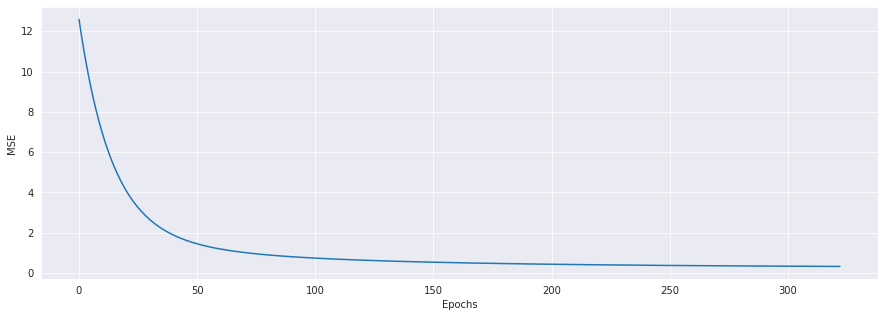

In [ ]:
sns.set_style('darkgrid')
sns.lineplot(data=mse)
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

In [ ]:
#X_testMean=X_test.mean(axis=0)
#X_testStdDev=X_test.std(axis=0)
#X_testMean[0]=0
#X_testStdDev[0]=1
X_testNorm=(X_test-X_trainMean)/X_trainStdDev

#y_testMean=y_test.mean()
#y_testStdDev=y_test.std()
y_testNorm=(y_test-y_trainMean)/y_trainStdDev

#sortidx = np.argsort(y_testNorm[:,0])
y_pred=np.dot(X_testNorm,b)
y_pred=y_pred*y_trainStdDev + y_trainMean
print(f'MSE in Test Set: {mean_squared_error(y_test,y_pred)/2}')

MSE in Test Set: 36820638634.1877


+-----------------+--------------------+
|   Actual Label  |  Predicted Value   |
+-----------------+--------------------+
|    [571000.]    |  [760613.4855841]  |
|    [502000.]    | [716179.93291969]  |
|    [660000.]    | [263452.28760984]  |
|    [397000.]    | [381965.51721088]  |
|    [771000.]    | [385890.96921887]  |
|    [210000.]    | [573933.97967336]  |
|    [394500.]    | [848458.29871881]  |
|    [255000.]    |  [390760.355386]   |
|    [465000.]    | [443020.89953469]  |
|    [600000.]    | [390974.73497615]  |
|    [591000.]    | [715889.36927328]  |
|    [518000.]    | [458939.93357361]  |
|    [290000.]    | [324099.82355582]  |
|    [299000.]    | [486938.73391093]  |
|     [90000.]    | [168500.01369726]  |
|    [285000.]    | [657931.16586942]  |
|    [803100.]    | [896729.72813423]  |
|    [304000.]    | [563503.17098312]  |
|    [310000.]    | [525320.02538738]  |
|    [300000.]    | [457609.13882501]  |
| [233166.666667] | [679261.35866601]  |
|    [555000.]  

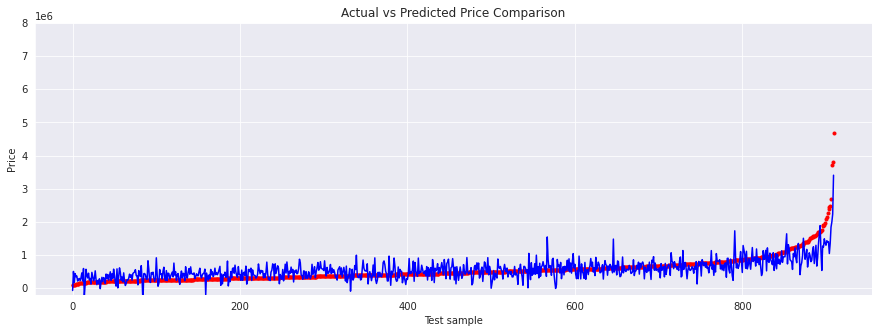

In [ ]:
table = PrettyTable()

#y_test=y_test*(maxy-miny) + miny
table.add_column("Actual Label", y_test)
table.add_column("Predicted Value", y_pred)
print(table)
sortidx1=np.argsort(y_test[:,0])
plt.rcParams["figure.figsize"] = (15,5)
plt.ylim(-0.2e6, 8e6)
plt.title('Actual vs Predicted Price Comparison')
plt.plot(y_test[sortidx1,0],'.', label='Actual Price', color='red')
plt.plot(y_pred[sortidx1,0],'-', label='Predicted Price', color='blue')
plt.ylabel('Price')
plt.xlabel('Test sample')
plt.show()

Convergence achieved at epoch 62.


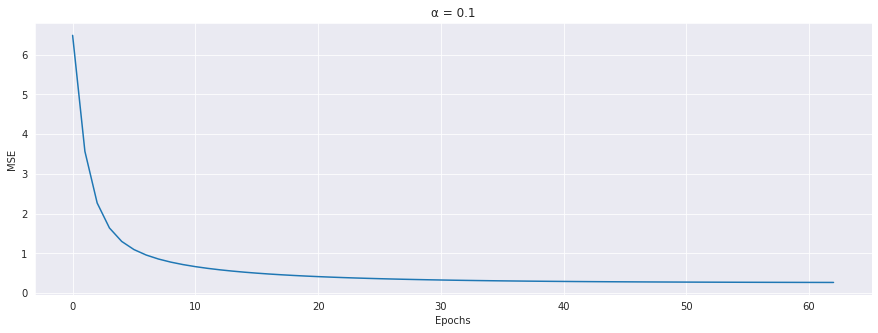

Convergence achieved at epoch 322.


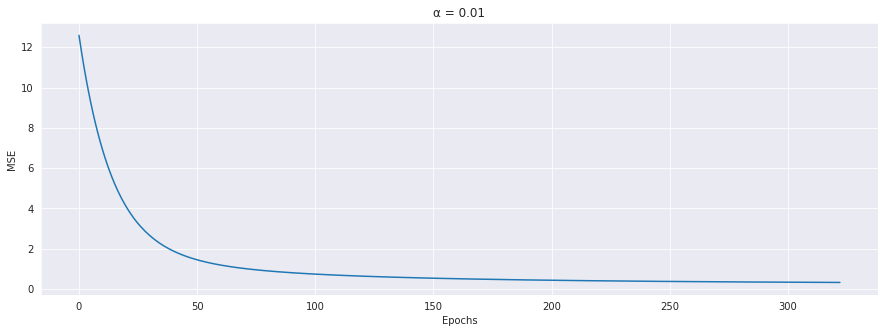

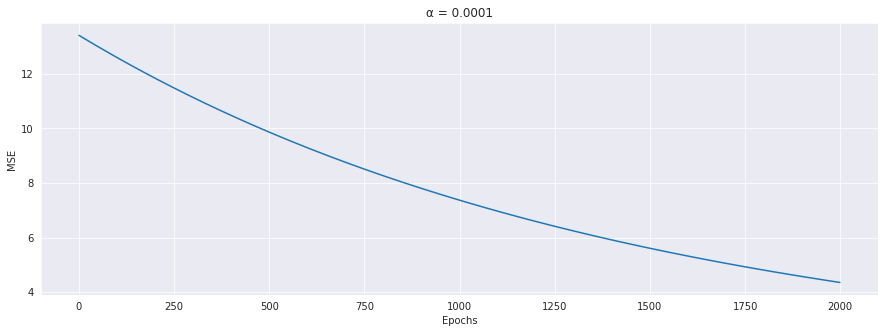

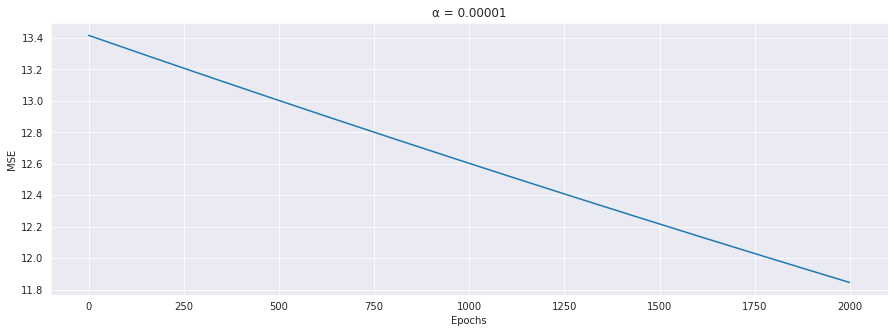

In [ ]:
b1, mse1 = gradient_descent(X_trainNorm, y_trainNorm, 0.1,2000)
# print(b1)
# print(mse1)
sns.set_style('darkgrid')
sns.lineplot(data=mse1)
plt.title('α = 0.1')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

b2, mse2 = gradient_descent(X_trainNorm, y_trainNorm, 0.01,2000)
# print(b2)
# print(mse2)
sns.set_style('darkgrid')
sns.lineplot(data=mse2)
plt.title('α = 0.01')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

b3, mse3 = gradient_descent(X_trainNorm, y_trainNorm, 0.0001,2000)
# print(b3)
# print(mse3)
sns.set_style('darkgrid')
plt.title('α = 0.0001')
sns.lineplot(data=mse3)
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

b4, mse4 = gradient_descent(X_trainNorm, y_trainNorm, 0.00001,2000)
# print(b4)
# print(mse4)
sns.set_style('darkgrid')
sns.lineplot(data=mse4)
plt.title('α = 0.00001')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

[4829357.33983484] [[ 0.00000000e+00 -5.64293597e+04  5.59343701e+04  1.52813256e+02
  -4.82622645e-01  5.21016977e+04  4.67192934e+05  4.99618273e+04
   1.96924889e+04  9.38110320e+01  5.90022240e+01 -2.48625491e+03
   7.93537979e+03  4.34020839e+05]]
MSE on test set using all features (Sci-kit): 25535117258.911842
+-----------------+--------------------+
|   Actual Label  |  Predicted Value   |
+-----------------+--------------------+
|    [571000.]    | [666067.04120337]  |
|    [502000.]    | [412750.33171049]  |
|    [660000.]    | [409195.57244646]  |
|    [397000.]    | [359823.44835175]  |
|    [771000.]    | [574293.03455536]  |
|    [210000.]    | [387776.27098012]  |
|    [394500.]    | [669687.33877193]  |
|    [255000.]    |  [399678.187451]   |
|    [465000.]    | [475535.99195623]  |
|    [600000.]    | [484405.04804935]  |
|    [591000.]    |  [647064.9192755]  |
|    [518000.]    | [373660.77688001]  |
|    [290000.]    | [363462.54453159]  |
|    [299000.]    |  [3966

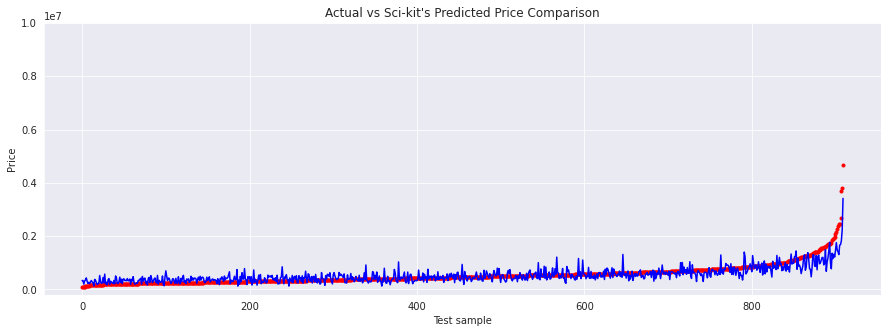

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
regressor = LinearRegression()
regressor.fit(X_train,y_train)
print(regressor.intercept_, regressor.coef_)
y_pred2 = regressor.predict(X_test)
print(f'MSE on test set using all features (Sci-kit): {mean_squared_error(y_test,y_pred2)/2}')
table = PrettyTable()
table.add_column("Actual Label", y_test)
table.add_column("Predicted Value", y_pred2)
print(table)
plt.ylim(-0.2e6, 10e6)
plt.title('Actual vs Sci-kit\'s Predicted Price Comparison')
plt.plot(y_test[sortidx1,0],'.', label='Actual Price', color='red')
plt.plot(y_pred2[sortidx1,0],'-', label='Predicted Price', color='blue')
plt.ylabel('Price')
plt.xlabel('Test sample')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     274.6
Date:                Sun, 19 Dec 2021   Prob (F-statistic):               0.00
Time:                        08:55:00   Log-Likelihood:                -51043.
No. Observations:                3638   AIC:                         1.021e+05
Df Residuals:                    3625   BIC:                         1.022e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.829e+06   4.64e+05     10.399      0.0

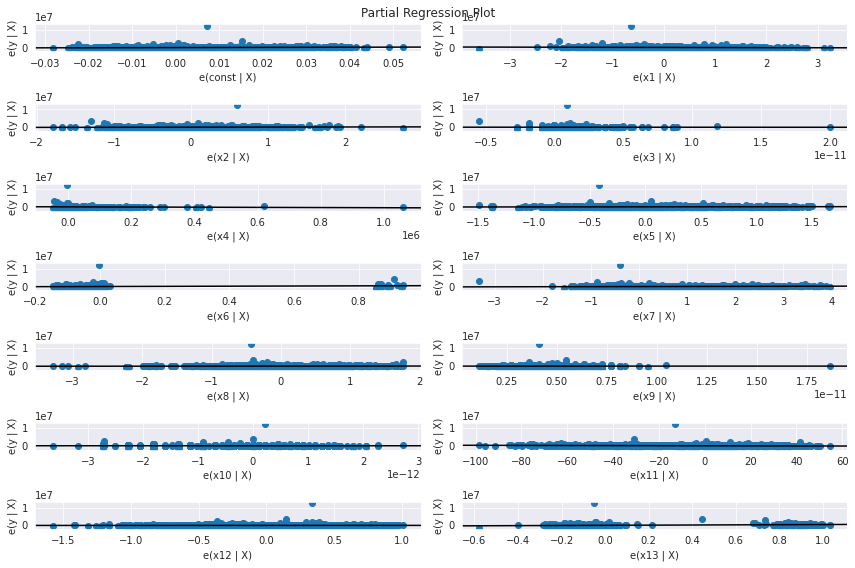

In [ ]:
mod = sm.OLS(y_train, X_train)
res = mod.fit()
print(res.summary())
#partial regression plots
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(res, fig=fig)

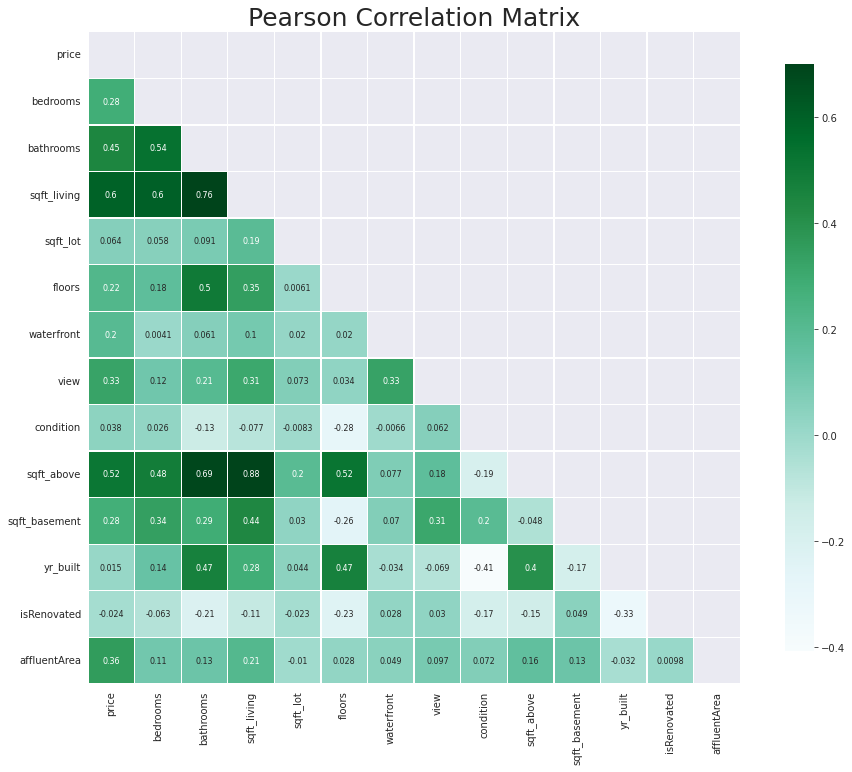

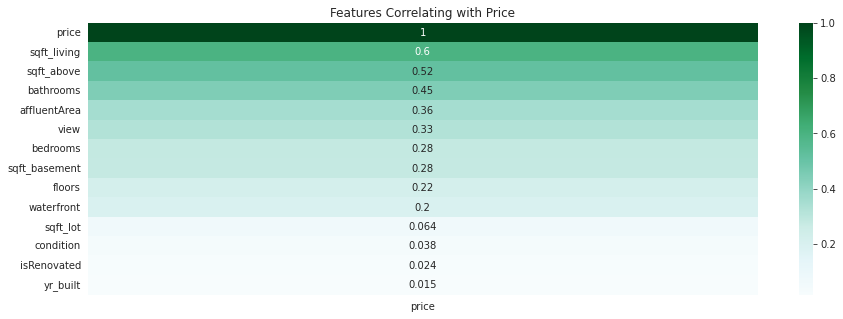

In [ ]:
features = ['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition','sqft_above','sqft_basement','yr_built','isRenovated','affluentArea']
X_trainDF=pd.DataFrame(X_train,columns=features)
X_trainDF['price'] = y_train
mask = np.zeros_like(X_trainDF[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(X_trainDF[features].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});
plt.show()
sns.heatmap(abs(X_trainDF.corr()[['price']]).sort_values(by='price', ascending=False), cmap="BuGn",linecolor='w',annot=True)
plt.title('Features Correlating with Price')
plt.show()

[11781.54773403] [[ 2.14095142e+02  2.86780732e+04  6.44951953e+04  5.03148239e+05
  -4.25765806e-01  4.68009160e+05]]
Test set error with hand-picked features: 28667588834.993126
+-----------------+--------------------+
|   Actual Label  |  Predicted Value   |
+-----------------+--------------------+
|    [571000.]    | [625785.06285014]  |
|    [502000.]    | [505891.78342572]  |
|    [660000.]    | [434062.58455131]  |
|    [397000.]    | [360255.99508509]  |
|    [771000.]    | [435721.96129583]  |
|    [210000.]    | [348756.62514819]  |
|    [394500.]    | [711851.30986552]  |
|    [255000.]    | [413830.87243912]  |
|    [465000.]    | [472578.42179029]  |
|    [600000.]    | [442600.84427613]  |
|    [591000.]    | [649335.52845136]  |
|    [518000.]    | [428689.80262541]  |
|    [290000.]    | [365884.23649453]  |
|    [299000.]    | [308078.54820062]  |
|     [90000.]    | [164634.80317498]  |
|    [285000.]    | [656500.13383473]  |
|    [803100.]    | [777792.61354894]  |


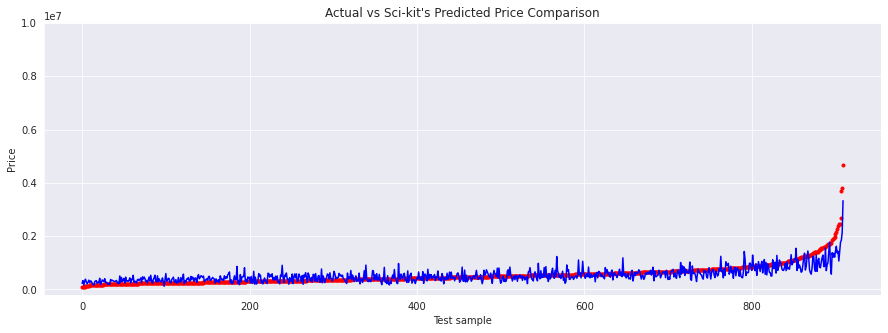

In [ ]:
X_train2 = np.array(X_trainDF[["sqft_living", "floors", "view", "waterfront", "sqft_basement", "affluentArea"]]) # inter-feature correlation threshold = 0.5

X_testDF=pd.DataFrame(X_test,columns=features)
X_testDF['price'] = y_test
X_test2 = np.array(X_testDF[["sqft_living", "floors", "view", "waterfront", "sqft_basement", "affluentArea"]])

regressor = LinearRegression()
regressor.fit(X_train2,y_train)
print(regressor.intercept_, regressor.coef_)
y_pred3 = regressor.predict(X_test2)
print(f'Test set error with hand-picked features: {mean_squared_error(y_test,y_pred3)/2}')
table = PrettyTable()
table.add_column("Actual Label", y_test)
table.add_column("Predicted Value", y_pred3)
print(table)
plt.ylim(-0.2e6, 10e6)
plt.title('Actual vs Sci-kit\'s Predicted Price Comparison')
plt.plot(y_test[sortidx1,0],'.', label='Actual Price', color='red')
plt.plot(y_pred3[sortidx1,0],'-', label='Predicted Price', color='blue')
plt.ylabel('Price')
plt.xlabel('Test sample')
plt.show()

MSE in Test Set with all features: `36820638634.1877` <br>
MSE in Test Set with all features (Sci-kit): `25535117258.911842` <br>
MSE in Test Set with 6 hand-picked features: `28667588834.993126` <br>

# Additional Analysis
*Data* Visualization for Lab Report

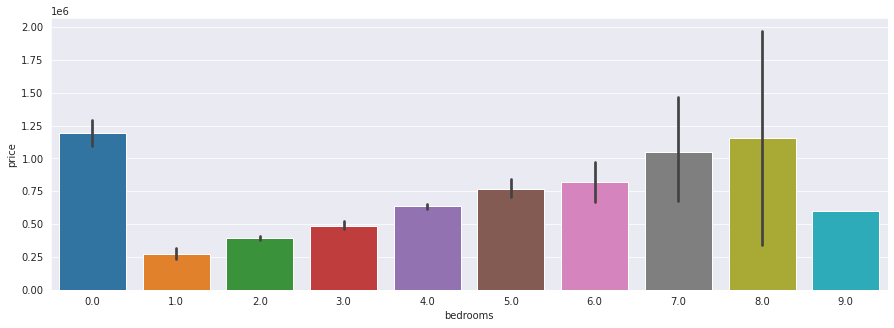

Houses with 0 bedrooms: 2
Houses with $0 price tag: 49


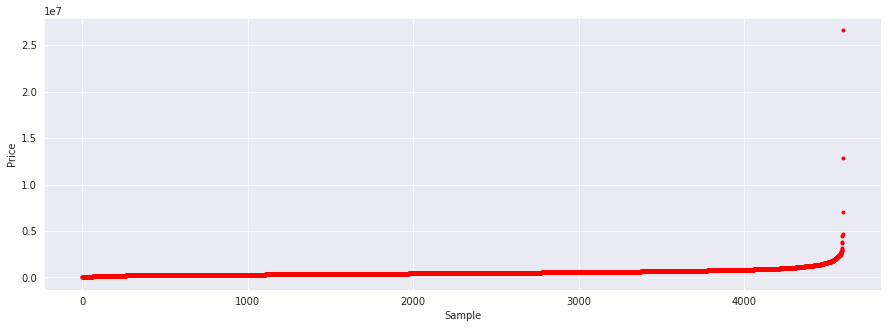

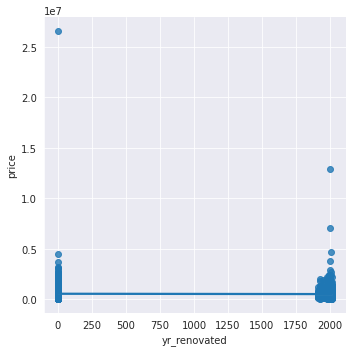

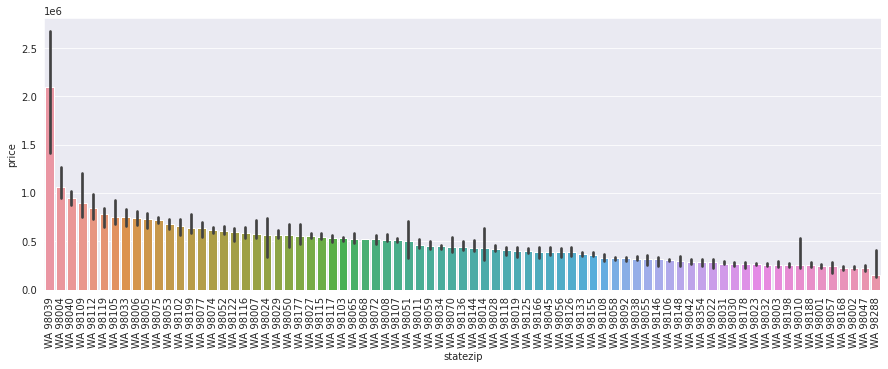

In [ ]:
data2=pd.read_csv('/content/data.csv')
sns.barplot(x=data2.bedrooms, y=data2['price'])
plt.show()
print("Houses with 0 bedrooms:", (data2.bedrooms == 0).sum())
print("Houses with $0 price tag:", (data2.price == 0).sum())
#sortidx = np.argsort(y[:,0])
plt.xlabel('Sample')
plt.ylabel('Price')
plt.plot(np.sort(data2['price'].values),'.', label='Price', color='red')
plt.show()

sns.lmplot(x = 'yr_renovated', y ='price', data = data2)
plt.show()

data2.bedrooms.value_counts()

result = data2.groupby(["statezip"])['price'].aggregate(np.median).reset_index().sort_values('price', ascending=False)
chart = sns.barplot(
    x='statezip',
    y='price',
    data=data2,
    order = result['statezip'],
    estimator=np.median    
)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.show()